Now we continue from the example from earlier in the notes, which aims for a numerical evaluation of
$$
I(\omega) = \int_{-1}^1 \sin(x^2) e^{i\omega x} dx.
$$
In this notebook, we do the numerical calculations, and analyse the accuracy.

We have already conveted to the contour integral:
$$
I = \sum_{\pm}\mp e^{\pm i\omega}\int_{0}^\infty \sin((\pm1+it)^2) e^{-\omega t} dt.
$$

To use Gauss Laguerre quadrature, we first require a simple change of variables $s=\omega t$. And it will be convinient to bring the sum inside of the integral. This gives us
$$
I = \int_{0}^\infty \left[\sum_{\pm}\mp i\frac{e^{\pm i\omega}}{\omega}\sin((\pm1+is/\omega)^2)\right] e^{-s} dt.
$$
Now define $f$ as the function inside the square brackets:

In [97]:
f(s,ω) =      im*exp(-im*ω)*sin((-1+im*s/ω)^2)/ω + # left contour
            - im*exp(im*ω)*sin((1+im*s/ω)^2)/ω # right contour

f (generic function with 1 method)

We need a practical way of accessing Gauss-Laguerre points. This course is not about computing these, so we will find an appropriate package. The following is a fast method for producing quadrature rules for most Gaussian quadrature routines, in $O(N)$ complexity (the reason for this efficiency is beyond the scope of this course). We will use Julia's help function to learn a bit about how to use Gauss Laguerre quadrature.

In [334]:
using FastGaussQuadrature

Enter `?(gausslaguerre)` if you want an explanation of this package.

Now construct our approximation. There are two steps: first we get the Gauss Laguerre weights and nodes, then we sum up like so, to approximate the contour integral.
$$
I(\omega) \approx I_N(\omega) = \sum_{j=1}^N w_jf(s,\omega)
$$

In [99]:
function I_N(ω, N)
    s ,w = gausslaguerre(N)
    return sum(w .* f.(s, ω))
end

I_N (generic function with 1 method)

In [101]:
I_N(100, 10)

-0.008337537980797519 + 0.0im

To measure the accuracy of our approximation $I_N$, we will evaluate the original (before deformation) integral to high precision via _brute force_, meaning that we will use a large number of points, rather than clever mathematics, for this approximation! It will be costly, but it is trustworthy. For this, we will use the `QuadGK` package, which applies a variant of Gauss quadrature adaptively over the integration range, until some tolerance is met. We could use tools from `FastGaussQuadrature` again, but we'd have to write our own code to keep increasing the points adaptively, which would be more effort than we need.

In [109]:
using QuadGK

Enter `?(quadgk)` if you want an explanation of this package.

In [113]:
I(ω) = quadgk(x->sin(x^2)*exp(im*ω*x), -1, 1, rtol=1e-14)[1] # we only care about first argument

I (generic function with 1 method)

We now plot the errors in our NSD approximation, to see how well it performs

In [284]:
using Plots, LaTeXStrings

In [294]:
ω_range = 10 .^ (0:5)

6-element Vector{Int64}:
      1
     10
    100
   1000
  10000
 100000

In [296]:
N_range = 1:5

1:5

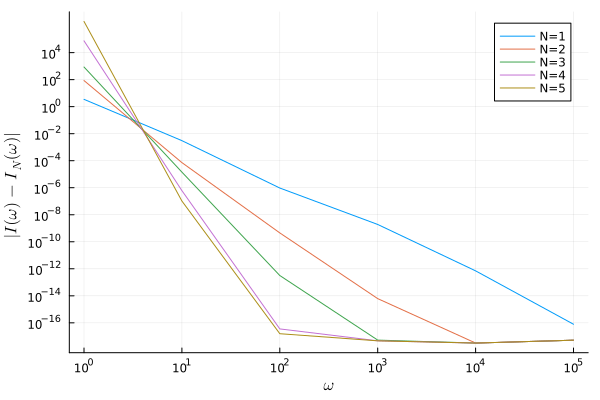

In [306]:
plot(ω_range, 
    [abs.(I.(ω_range) - I_N.(ω_range, N)) for N in N_range],
    labels= permutedims(["N=$N" for N in N_range]),
    xticks=ω_range,
    yticks=10.0 .^ (-16:2:4),
    xlabel=L"\omega",
    ylabel = L"|I(\omega)-I_N(\omega)|",
    yscale=:log10,
    xscale=:log10)

We see agreement with our theory, convergence is faster for higher $N$. Note that our theory does not guarantee fast convergence for lower values of $\omega$, but in practice, this is observed. As mentioned earlier in the lecture notes, this is typical of NSD.

Now let's focus on a specific example. We see that $I_3(1000)$ is at machine precision, this is using **just three** points! Let compare the CPU time, against the `quadgk` _brute force_ approach:

In [207]:
@time(I_N(1000, 3))

  0.000017 seconds (30 allocations: 1.938 KiB)


0.001392809496908004 + 0.0im

In [240]:
@time(I(1000))

  0.022514 seconds (18 allocations: 3.965 MiB)


0.001392809496907999 - 1.666960840196463e-18im

We see that our NSD approach is considerably faster than the adaptive quadrature approach!

Now let's see how many points a standard Gauss rule would need to evaluate the original integral $I(\omega)$ to machine precision, noting that our method did this in **just three points**. To do this, we create an approximation of our original integral via standard Gauss (Legendre) quadrature, which is designed for integrals of the form
$$
\int_{-1}^1 f(x)~ dx
$$
where $f$ can be well-approximated by a polynomial.

In [250]:
function slow_gauss_approx(ω, N)
    IG(x) = sin(x^2)*exp(im*ω*x)
    x, w = gausslegendre(N)
    return sum(w .* IG.(x))
end

slow_gauss_approx (generic function with 1 method)

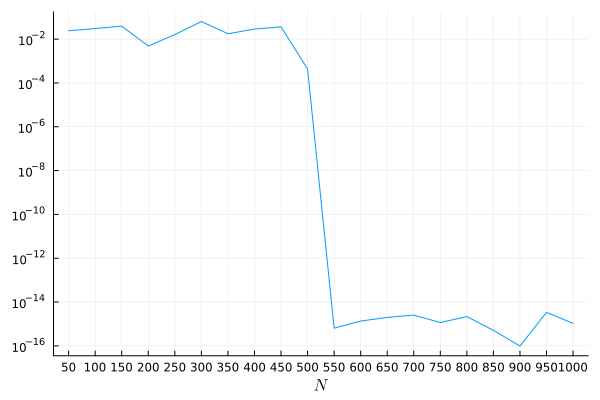

In [308]:
N_range = 50:50:1000
ω = 1000
I_ref =  I(ω) #this will save time below
plot(N_range, abs.(slow_gauss_approx.(ω, N_range) .- I_ref),
    xticks = N_range,
    yscale=:log10,
    xlabel=L"N",
    yticks=10.0 .^ (-16:2:4),
    label="")

We see that it takes **over five hundred** Gauss points to approximate the original integral $I(\omega)$ to machine precision! Considerably more than **just three**, which was all that we needed after deforming onto the steepest descent contour.